# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/bfdd220543cbde7e6d31f5e9890c888e683804571bd8e92083ed52f4.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Atlanta, Georgia, United States**, and the stations the data comes from are shown on the map below.

In [3]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

#leaflet_plot_stations(400,'bfdd220543cbde7e6d31f5e9890c888e683804571bd8e92083ed52f4')

In [4]:
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/bfdd220543cbde7e6d31f5e9890c888e683804571bd8e92083ed52f4.csv')

In [5]:
df.head(5)

,ID,Date,Element,Data_Value
0,USC00090219,2011-06-14,TMAX,311
1,USC00098436,2008-09-29,TMIN,122
2,USW00053863,2010-04-16,TMIN,122
3,USC00090181,2009-10-27,TMIN,39
4,USW00093801,2011-11-30,TMAX,78


In [6]:
df.loc[:,'Data_Value'] *= 0.1 # Dividing all temperature entries by 10 to convert them to degree celsius
df['Date'] = pd.to_datetime(df['Date']) # Changing the dtype of the date to pandas datetime 

# Setting up the sorted multi-index consisting of month and days so as to help grouping rows later for each 
# day of the year
df['Day'] = pd.DatetimeIndex(df['Date']).day 
df['Month'] = pd.DatetimeIndex(df['Date']).month 
df = df.set_index(['Month','Day']) 
df.sort_index(inplace = True)

# Discarding all the entries for 29th Feb of any year; only 365 days of the year are considered
selected_df = df.loc[2,29] 
df = df[~df.index.isin(selected_df.index)]

In [7]:
df.head(5)

ID       Date Element  Data_Value
Month Day                                            
1     1    USC00092485 2012-01-01    TMAX        18.9
      1    USW00003888 2015-01-01    TMIN        -1.0
      1    USW00003888 2015-01-01    TMAX        13.3
      1    USC00092485 2012-01-01    TMIN         3.3
      1    USW00003888 2014-01-01    TMIN        -0.5

In [8]:
# Splitting dataframes into two - one for 2005-2014 and another for 2015
df['Year'] = pd.DatetimeIndex(df['Date']).year
df_2015 = df[df['Year'] == 2015] 
df = df[df['Year'] != 2015] 

# Creating two dataframes for 2005-2014 - one each for max and min
max_temp_df = df[df['Element'] == 'TMAX'] 
min_temp_df = df[df['Element'] == 'TMIN'] 

# The following gives pandas series with 365 entries corresponding to the max/min temperatures 
# over the decade 2005-2014 for each day of the year
max_temp = max_temp_df.groupby(level = ['Month', 'Day'])['Data_Value'].max()  
min_temp = min_temp_df.groupby(level = ['Month', 'Day'])['Data_Value'].min()

# Creating two dataframes for 2015 - one each for max and min
max_temp_df_2015 = df_2015[df_2015['Element'] == 'TMAX']
min_temp_df_2015 = df_2015[df_2015['Element'] == 'TMIN'] 

# The following gives dataframes with 365 rows corresponding to the max/min temperatures for each day of 
# the year 2015 and two columns in total viz one for temperature values and another for dates stored 
# as the pandas datatime object  
max_temp_df_2015 = max_temp_df_2015.groupby(level = ['Month', 'Day']).max()[['Data_Value', 'Date']]
min_temp_df_2015 = min_temp_df_2015.groupby(level = ['Month', 'Day']).min()[['Data_Value', 'Date']]

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker

# Need 365 days array for plotting in pandas datetime format; year does not matter so taken 2015 
# for convenience
date_range = df_2015['Date'].unique() 

# Creating figure and an axis
fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (10,5) ) 
ax.set_title('New Orleans Record Temperatures (2005-2014) and 2015') # Setting the title
ax.yaxis.grid() # Setting up the horizontal grid lines in the background

# Plotting graphs and filling in between region
# Google Material Design color palette (https://material.io/guidelines/style/color.html) is used below: 
plt.plot(date_range, max_temp.values, '#FF9100', linewidth = 1, alpha=0.75, label = '2005-2014 Highs')
plt.plot(date_range, min_temp.values, '#80D8FF', linewidth = 1, alpha=0.75, label = '2005-2014 Lows') 
plt.fill_between(date_range, min_temp, max_temp, facecolor='#EEEEEE')

In [25]:
plt.legend(loc = 1).get_frame().set_edgecolor('white') 

# Labels for the legends of the scatter plots below
my_label_max = "2015 Highs"
my_label_min = "2015 Lows"

In [26]:
for idx, rows in max_temp_df_2015.iterrows():
    if rows['Data_Value'] > max_temp.loc[idx]:
        plt.scatter(rows['Date'], rows['Data_Value'], c = '#E65100', marker = '.', label = my_label_max)
        my_label_max = "_nolegend_" # To avoid duplicate labels in the legend
for idx, rows in min_temp_df_2015.iterrows():
    if rows['Data_Value'] < min_temp.loc[idx]:
        plt.scatter(rows['Date'], rows['Data_Value'], c = '#0091EA', marker = '.', label = my_label_min)
        my_label_min = "_nolegend_"
        
# Adding the labels for the max and min points to the above legend 
ax.legend(loc = 1).get_frame().set_edgecolor('white')

In [27]:
# Setting the limits for x-axis to fit the dates perfectly
xmin, xmax = date_range[0], date_range[-1]
ax.set_xlim(xmin, xmax)

# Locating 12 positions for the 15th of each month on x-axis 
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=15))

# Labeling the 12 months on x-axis at the positions located above
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# Centering month labels in between the ticks and removing undesirable ticks
xticks = ax.xaxis.get_minor_ticks()
for xtick in xticks:
    xtick.tick1line.set_markersize(0)
    xtick.tick2line.set_markersize(0)
    xtick.label1.set_horizontalalignment('center')

In [28]:
ax.set_ylabel('Temperatures $(^{\circ}$C)') # Set label for y-axis

# Setting the temperature limits for y-axis from -10 to 50 degrees Celsius
ymin, ymax = -10, 50
ax.set_ylim(ymin, ymax) 

yticks = ax.yaxis.get_major_ticks()
yticks[0].label1.set_visible(False) # Making 50 degrees Celsius disappear to make the graph look cleaner
yticks[1].label1.set_visible(False) # Making -10 degrees Celsius disappear to make the graph look cleaner
ax.yaxis.set_major_locator(ticker.MultipleLocator(10)) # Putting major ticks at every 10 degrees Celsius
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5)) # Putting minor ticks at every 5 degrees Celsius

In [29]:
ax2 = ax.twinx() # Create a twin y-axis sharing the x-axis with the previous y-axis
ax2.set_ylabel('Temperatures $(^{\circ}$F)') # Setting label for y-axis
def C_to_F(temp_c): # Celsius to Fahrenheit  
    return 9/5 *temp_c + 32
ax2.set_ylim(C_to_F(ymin), C_to_F(ymax)) # (ymin, ymax) are defined above
ax2.yaxis.set_major_locator(ticker.MultipleLocator(20)) # Putting major ticks at every 20 degrees Fahrenheit
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(5)) # Putting major ticks at every 5 degrees Fahrenheit


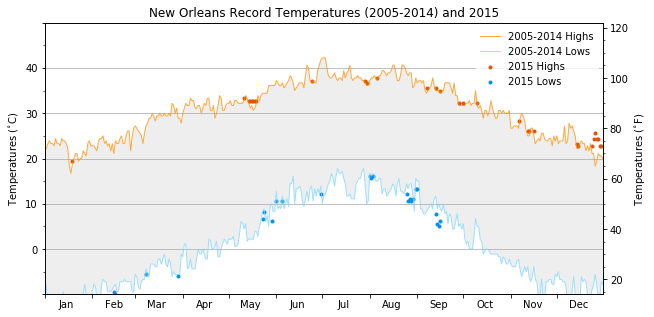

In [30]:
plt.show()